# issue-16

Repeat the experiment in #15, but this time, compute the relative error in prediction vs the Cramer rao bound.

X axis: Theta, ranging from 0 to 1.

Y axis: Relative prediction error, I.e., for each theta, the absolute value of the prediction error, divided by the CR bound for that theta.

Y axis: another plot, the CR bound; perhaps in Log scale. Try to make to lines on the same plot, or if not possible, try to make one graph on top of each other.

In [1]:
# import library
%run lib.ipynb
np.set_printoptions(precision=4)

In [2]:
from scipy import stats
from scipy.stats import lognorm

# sample from lognormal
def sample_lognormal(config, size):
    return lognorm.rvs(s=config, size=size, random_state=RANDOM_STATE)

def next_config(search_space):

    """
    return a (uniform) random parameter within search_space
    """
    low = search_space[0]
    high = search_space[1]
    return np.random.uniform(low, high, size=1)[0]


In [3]:
NUM_BINS = 346

def issue_16(search_space, M=256, N=1000, N_training_samples=1000):
    """
    Arguments:
        - M: number of observations in sample
        - N: number of samples
    """
    
    f = sample_lognormal
    
    # Generate (true) synthetic data using f (within search_space)
    samples_true, H_true, true_params = generate_data(N=N, 
                                   M=M, 
                                   sample=f, 
                                   nextConfig=lambda: next_config(search_space),
                                   nbins=-1)
    
    # Fit a DNN model
    print(f'training ({N_training_samples} samples) ...', end=' ')
    nbins = H_true.shape[1]
    raw_train, H_train, train_params = generate_data(N=N_training_samples, 
                                   M=M, 
                                   sample=f, 
                                   nextConfig=lambda: next_config(search_space),
                                   nbins=nbins)
    
    dnn_model, history = dnn_fit(X_train=H_train, y_train=train_params)
    print(f'done.')
    
    # Predict the parameters on the true samples
    pred_params = dnn_model.predict(H_true).flatten()
       
    return true_params, pred_params

## Fit (lognormal)

In [4]:
M = 256
# search_space
search_space = np.array([0.01, 1.0])
print(f'*** search_space: {search_space}')
true_params, pred_params = issue_16(search_space=search_space, M=M, N=1000, N_training_samples=1000)

*** search_space: [0.01 1.  ]
training (1000 samples) ... done.


In [5]:
# Calculate the CR bound on the true_params: sqrt(2𝜃^2)/n
n = M
CR_bound = np.sqrt(2*np.square(true_params)/n)

# Plot

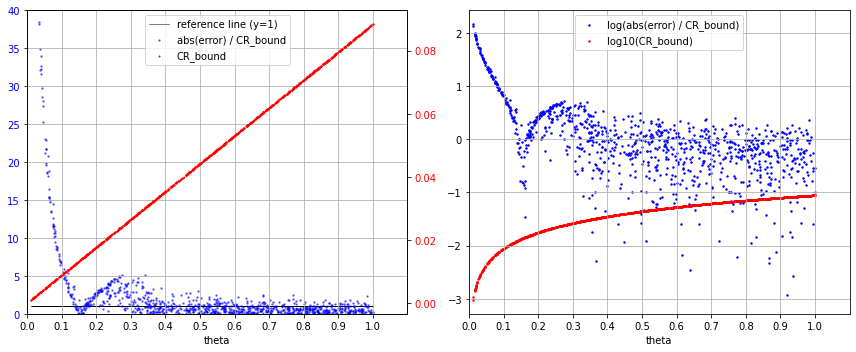

In [6]:
def plot(true_params, pred_params, CR_bound):
    
    x = true_params
    y = np.abs(pred_params - true_params) / CR_bound
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
        
    log_scale = False
    for ax in axes:
    
        ax.set_xlabel('theta')
        ax.set_xlim(0, 1.1*max(x))
        ax.set_xticks(np.arange(0, max(x)+0.1, 0.1))
        ax.grid()
        
        if log_scale:

            # relation
            color='blue'
            ax.scatter(x, np.log10(y), zorder=1, s=2, c=color, label='log(abs(error) / CR_bound)')

            # CR
            color='red'
            ax.scatter(x, np.log10(CR_bound), zorder=1, s=2, c=color, label='log10(CR_bound)')
            ax.legend(loc='upper center')

        else:
            
            # reference line
            ax.plot(x, np.ones_like(x), zorder=0, c='black', linewidth=0.5, label='reference line (y=1)')

            # relation
            color = 'blue'
            ax.tick_params(axis='y', labelcolor=color)
            ax.scatter(x, y, zorder=1, s=2, c=color, alpha=0.5, label='abs(error) / CR_bound')
            ax.set_ylim(0, 40)
           
            # CR_bound
            color = 'red'
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ax2.tick_params(axis='y', labelcolor=color)
            ax2.scatter(x, CR_bound, zorder=2, s=1, c=color, label='CR_bound')

            # legend for both ax and ax2
            lines, labels = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax2.legend(lines + lines2, labels + labels2, loc='upper center')
        
        log_scale = True
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

plot(true_params, pred_params, CR_bound)